TensorFlow est une bibliothèque de Deep Learning développée par Google. Elle permet de créer, entraîner et déployer des réseaux de neurones (CNN, RNN, Transformers, etc.) pour des tâches comme la vision, le texte, l’audio, la prédiction…

Keras est une interface haut niveau pour créer des modèles de deep learning facilement. Elle peut fonctionner avec TensorFlow (le plus courant). Elle simplifie l’écriture de code pour l’apprentissage profond.

scikit-learn est une bibliothèque pour le Machine Learning classique (hors deep learning) : régression, classification, clustering, réduction de dimension, évaluation, etc.



In [ ]:
pip install tensorflow keras pillow scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split


MobileNetV2 est un modèle pré-entraîné (un CNN léger souvent utilisé pour la classification d’images).

preprocess_input prépare l’image (redimension, normalisation, etc.) pour que MobileNetV2 puisse la lire correctement.

decode_predictions convertit la sortie brute du modèle (vecteur de probabilités) en noms d’objets lisibles

image fournit des fonctions pour charger une image à partir d’un fichier, la transformer en tableau numpy, etc.

os permet de travailler avec le système de fichiers : créer des dossiers, parcourir des fichiers, vérifier s’ils existent, etc.

shutil sert à copier, déplacer ou supprimer des dossiers/fichiers entiers. Plus pratique que os pour la manipulation physique de données (ex : copier un dossier d’images).

train_test_split est la fonction de scikit-learn qui permet de séparer un dataset en deux parties :
Entraînement (train)
Test (test)


In [6]:

def classifier_image(image_path):
    """Classifie une image avec MobileNetV2 pré-entraîné"""
    # Charger le modèle
    model = MobileNetV2(weights='imagenet')
    
    # Charger et prétraiter l'image
    img = image.load_img(image_path, target_size=(224, 224))
    # Convertit l'image au format tableau NumPy (hauteur, largeur, canaux RGB)
    img_array = image.img_to_array(img)

    # Ajoute une dimension en plus pour simuler un "batch" de taille 1
    # le modèle attend une entrée sous la forme (batch_size(1), height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    # Applique le prétraitement spécifique à MobileNetV2 (normalisation des pixels, etc.)
    img_array = preprocess_input(img_array)
    
    # Passe l'image dans le modèle pour obtenir les probabilités des classes
    predictions = model.predict(img_array)

    # Convertit les probabilités en labels de classes lisibles (ex: "chien", "chat")
    # et récupère les 5 prédictions les plus probables
    decoded = decode_predictions(predictions, top=5)[0]
    
    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Image
    axes[0].imshow(image.load_img(image_path))
    axes[0].set_title('Image à classifier')
    axes[0].axis('off')
    
    # Prédictions
    # Récupère uniquement les labels (noms des classes)
    labels = [d[1] for d in decoded]

    # Récupère les scores (probabilités) et les convertit en pourcentage
    scores = [d[2] * 100 for d in decoded]
    
    # Crée un histogramme horizontal des scores pour les 5 meilleures classes
    axes[1].barh(labels, scores, color='skyblue')
    axes[1].set_xlabel('Confiance (%)')
    axes[1].set_title('Top 5 Prédictions')
    # Inverse l'ordre vertical pour que la meilleure prédiction soit en haut
    axes[1].invert_yaxis()
    
    # --- Annotation des barres ---
    # Ajoute le pourcentage sur chaque barre de l'histogramme
    for i, (label, score) in enumerate(zip(labels, scores)):
        axes[1].text(score + 1, i, f'{score:.1f}%', va='center')
        # (score + 1) décale légèrement le texte à droite de la barre
        # va='center' centre verticalement le texte sur la barre

    plt.tight_layout()
    plt.show()
    
    # Résultat
    print(f"\n=== RÉSULTAT ===")
    # Affiche le label (nom de classe) de la prédiction la plus probable.
    #decoded[0] est la meilleure prédiction, [1] récupère le nom de la classe
    print(f"Classe prédite: {decoded[0][1]}")

    #Affiche la probabilité associée à cette classe, convertie en pourcentage (*100), arrondie à 2 décimales (:.2f).
    print(f"Confiance: {decoded[0][2]*100:.2f}%")
    print(f"\nTop 5:")
    for i, (_, label, score) in enumerate(decoded, 1):
        print(f"  {i}. {label}: {score*100:.2f}%")
        '''Parcourt les 5 prédictions retournées dans decoded.
        i est l’index (commence à 1 grâce à enumerate(decoded, 1))
        _ correspond à l’ID WordNet (pas utile ici)
        label est le nom de la classe
        score est la probabilité (on la convertit en %)
        Le print affiche sous forme lisible'''
    
    return decoded



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


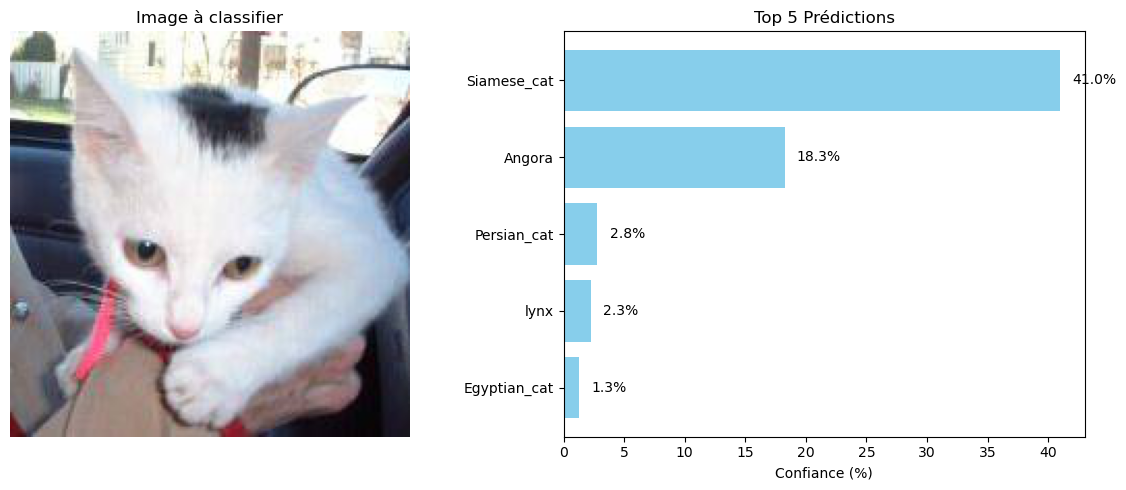


=== RÉSULTAT ===
Classe prédite: Siamese_cat
Confiance: 40.99%

Top 5:
  1. Siamese_cat: 40.99%
  2. Angora: 18.26%
  3. Persian_cat: 2.80%
  4. lynx: 2.26%
  5. Egyptian_cat: 1.28%


In [5]:
# Test
result = classifier_image('cat.jpg')

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
!cp -r ~/.keras/datasets/cats_and_dogs_filtered/train ./mon_dataset

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 344s 5us/step


In [ ]:
!cp -r ~/.keras/datasets/cats_and_dogs_filtered/train ./mon_dataset


In [ ]:
!cp -r ~/.keras/datasets/cats_and_dogs_filtered/validation ./test

In [ ]:
def creer_dataset(dossier_source, dossier_dest, test_size=0.2):
    
    # Création des dossiers principaux train et test dans dossier_dest.
    for split in ['train', 'test']:
        os.makedirs(os.path.join(dossier_dest, split), exist_ok=True)
    
    # Liste des classes : tous les sous-dossiers dans dossier_source représentent des classes.
    #On ne prend que les dossiers (pas les fichiers).
    classes = [d for d in os.listdir(dossier_source) 
               if os.path.isdir(os.path.join(dossier_source, d))]
    # Initialisation d'un dictionnaire de statistiques pour garder 
    # le nombre total d’images, de train, de test et par classe.
    #'classes': {} initialise un dictionnaire vide qui servira à stocker les statistiques par classe.
    stats = {'total': 0, 'train': 0, 'test': 0, 'classes': {}}
    
    for classe in classes:
        print(f"Traitement de la classe: {classe}")
        
        #Lister les images de la classe dans le dossier correspondant.
        #On prend seulement les fichiers avec extensions .jpg, .jpeg, .png (insensible à la casse).
        chemin_classe = os.path.join(dossier_source, classe)
        images = [f for f in os.listdir(chemin_classe) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Séparation aléatoire des images en train et test.random_state=42 
        # permet de reproduire exactement le même split à chaque exécution.
        train_imgs, test_imgs = train_test_split(
            images, test_size=test_size, random_state=42
        )
        
        # Création des sous-dossiers pour chaque classe dans train et test.
        for split in ['train', 'test']:
            os.makedirs(os.path.join(dossier_dest, split, classe), exist_ok=True)
        
        # Copie des images dans les dossiers train et test respectifs.
        # shutil.copy2 conserve les métadonnées du fichier (date, permissions, etc.)
        for img in train_imgs:
            src = os.path.join(chemin_classe, img)
            dst = os.path.join(dossier_dest, 'train', classe, img)
            shutil.copy2(src, dst)
        
        for img in test_imgs:
            src = os.path.join(chemin_classe, img)
            dst = os.path.join(dossier_dest, 'test', classe, img)
            shutil.copy2(src, dst)
        
        # Mise à jour des statistiques globales et par classe.
        # Affichage du nombre d’images train/test pour cette classe.
        stats['total'] += len(images)
        stats['train'] += len(train_imgs)
        stats['test'] += len(test_imgs)
        stats['classes'][classe] = {
            'total': len(images),
            'train': len(train_imgs),
            'test': len(test_imgs)
        }
        
        print(f"  Train: {len(train_imgs)}, Test: {len(test_imgs)}")
    
    # Affichage complet des statistiques finales du dataset : nombre total, répartition train/test, et détail par classe.
    print(f"\n{'='*50}")
    print("STATISTIQUES DU DATASET")
    print(f"{'='*50}")
    print(f"Images totales: {stats['total']}")
    print(f"Train: {stats['train']} ({stats['train']/stats['total']*100:.1f}%)")
    print(f"Test: {stats['test']} ({stats['test']/stats['total']*100:.1f}%)")
    print(f"\nDétail par classe:")
    for classe, data in stats['classes'].items():
        print(f"  {classe}: {data['total']} (train: {data['train']}, test: {data['test']})")
    print(f"{'='*50}\n")
    
    return stats



In [10]:
# Utilisation
stats = creer_dataset('mon_dataset', 'dataset_prepare', test_size=0.2)

Traitement de la classe: dogs
  Train: 800, Test: 200
Traitement de la classe: cats
  Train: 800, Test: 200

STATISTIQUES DU DATASET
Images totales: 2000
Train: 1600 (80.0%)
Test: 400 (20.0%)

Détail par classe:
  dogs: 1000 (train: 800, test: 200)
  cats: 1000 (train: 800, test: 200)



In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

ImageDataGenerator : permet de prétraiter et d’augmenter les images en temps réel lors de l’entraînement.
Exemple d’utilisation : rotation, zoom, translation, retournement horizontal, normalisation des pixels, etc.

MobileNetV2 : un modèle CNN pré-entraîné sur ImageNet.
Utilisé souvent pour le transfer learning (apprentissage par transfert) : on reprend les poids appris sur ImageNet et on adapte le modèle à notre tâche spécifique.
Avantages : léger, rapide, efficace pour les appareils mobiles et projets avec ressources limitées.

Dense : couche entièrement connectée, utilisée généralement en sortie ou pour classifier les caractéristiques extraites.

GlobalAveragePooling2D : remplace souvent les couches Flatten pour réduire le risque d’overfitting. Elle fait la moyenne des valeurs dans chaque canal de la feature map.

Dropout : couche de régularisation qui éteint aléatoirement un pourcentage de neurones pendant l’entraînement pour réduire le surapprentissage.

Model : classe de Keras pour définir un modèle à partir de couches existantes.
Très utilisé pour créer un modèle personnalisé en combinant un backbone pré-entraîné (ex. MobileNetV2) avec de nouvelles couches pour notre tâche.

Adam : un optimiseur populaire basé sur la descente de gradient adaptative.
Avantages : converge rapidement et fonctionne bien dans la plupart des cas pour le deep learning.
On peut régler le learning rate et d’autres hyperparamètres pour contrôler l’entraînement.


In [ ]:
def creer_modele(num_classes, img_size=224):
    """Crée un modèle de classification d'images avec transfer learning."""
    
    
    # Base pré-entraînée MobileNetV2
   
    base_model = MobileNetV2(
        input_shape=(img_size, img_size, 3),  # Taille des images d'entrée
        include_top=False,                    # Supprime la couche de sortie originale
        weights='imagenet'                    # Utilise les poids pré-entraînés sur ImageNet
    )
    
    
    # Geler les couches de base
    
    base_model.trainable = False  # Les poids du MobileNetV2 ne seront pas entraînés
    
   
    # Ajouter des couches personnalisées
    
    x = base_model.output                 # Sortie du backbone MobileNetV2
    x = GlobalAveragePooling2D()(x)      # Réduit chaque feature map à une moyenne (moins de paramètres)
    x = Dense(128, activation='relu')(x) # Couche fully connected pour apprendre des patterns spécifiques
    x = Dropout(0.5)(x)                  # Régularisation : éteint 50% des neurones pour éviter l'overfitting
    predictions = Dense(num_classes, activation='softmax')(x)  # Couche de sortie avec softmax pour classification multi-classes
    
   
    # Créer le modèle final
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model  # Retourne le modèle prêt à être compilé et entraîné


In [ ]:
def entrainer_modele(dataset_dir, num_classes, epochs=10, batch_size=32):
    """Entraîne un modèle de classification d'images sur un dataset personnalisé."""
    
    
    # Data augmentation pour le train
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,             # Normaliser les pixels entre 0 et 1
        rotation_range=20,           # Rotation aléatoire ±20°
        width_shift_range=0.2,       # Décalage horizontal aléatoire 20%
        height_shift_range=0.2,      # Décalage vertical aléatoire 20%
        horizontal_flip=True,        # Flip horizontal aléatoire
        zoom_range=0.2,              # Zoom aléatoire ±20%
        fill_mode='nearest'          # Remplissage des pixels manquants
    )
    
    # Pas d'augmentation pour le test, seulement normalisation
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    
    # Générateurs d'images
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_dir, 'train'),  # Dossier train
        target_size=(224, 224),              # Redimensionner les images
        batch_size=batch_size,
        class_mode='categorical'             # Labels one-hot
    )
    
    test_generator = test_datagen.flow_from_directory(
        os.path.join(dataset_dir, 'test'),   # Dossier test
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    
    # Créer le modèle avec transfer learning
    
    model = creer_modele(num_classes)
    
    
    # Compiler le modèle
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Optimiseur Adam
        loss='categorical_crossentropy',      # Perte pour classification multi-classes
        metrics=['accuracy']                   # Suivi de l'accuracy
    )
    
    
    # Entraîner le modèle
    
    print("\nDébut de l'entraînement...")
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
        verbose=1
    )

    '''model.fit(...) : lance l’entraînement du modèle sur les données.
    train_generator : le générateur qui fournit les batches d’images et de labels pour l’entraînement.
    epochs=epochs : le nombre de passages complets sur tout le jeu de données d’entraînement.
    validation_data=test_generator : après chaque epoch, le modèle est évalué sur le jeu de test/validation pour suivre sa performance sur des données qu’il n’a pas vues.
    verbose=1 : affiche la progression de l’entraînement (barre + métriques).'''
    
    
    # Évaluer le modèle sur le test set
    
    print("\nÉvaluation sur le test set:")
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Précision test: {test_acc*100:.2f}%")
    
    
    # Sauvegarder le modèle
    
    model.save('mon_classificateur.h5')
    print("\nModèle sauvegardé: mon_classificateur.h5")
    
    
    # Visualiser l'entraînement (accuracy et loss)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title('Précision')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
   
    # Retourner le modèle, l'historique et les indices de classes
    
    return model, history, train_generator.class_indices


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.

Début de l'entraînement...


/Users/bayala/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8664 - loss: 0.3275 - val_accuracy: 0.9825 - val_loss: 0.0457

Évaluation sur le test set:
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 731ms/step - accuracy: 0.9802 - loss: 0.0488


Précision test: 98.25%

Modèle sauvegardé: mon_classificateur.h5


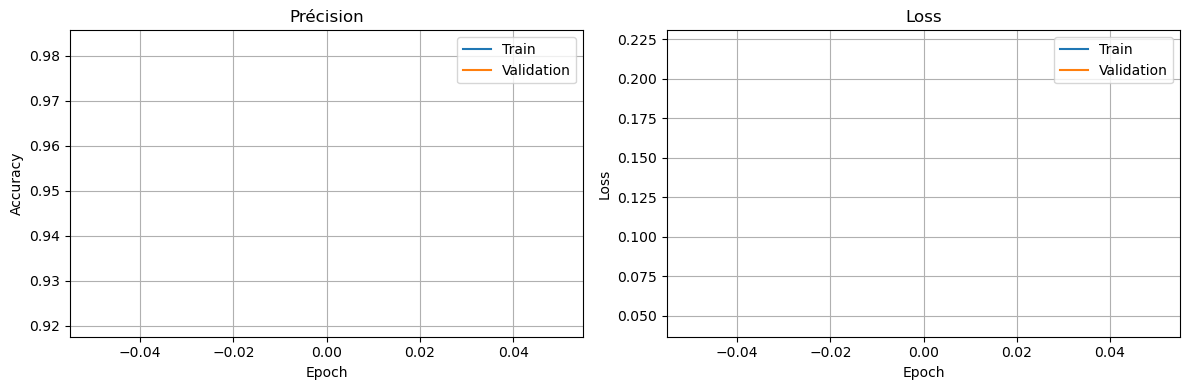

In [23]:
# Utilisation
model, history, class_indices = entrainer_modele(
    'dataset_prepare',
    num_classes=2,  # Nombre de classes dans votre dataset
    epochs=1
)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

class ClassificateurPersonnalise:
    """Classificateur utilisant un modèle Keras sauvegardé"""

    def __init__(self, model_path, class_indices):
        # Charger le modèle entraîné sauvegardé (.h5 par exemple)
        self.model = load_model(model_path)

        # Inverser le dictionnaire {nom_classe: indice} -> {indice: nom_classe}
        # Cela facilite la récupération du nom de la classe à partir de la prédiction (argmax)
        self.classes = {v: k for k, v in class_indices.items()}

    def predire(self, image_path):
        """Charge une image, la prétraite, et renvoie la prédiction"""
        
        # Charger l'image disque et la redimensionner au format du modèle (224x224)
        img = image.load_img(image_path, target_size=(224, 224))
        
        # Convertir l'image en tableau numpy
        img_array = image.img_to_array(img)
        
        # Ajouter une dimension batch pour devenir (1,224,224,3)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Normaliser les pixels entre 0 et 1
        img_array = img_array / 255.0
        
        # Obtenir les prédictions du modèle
        predictions = self.model.predict(img_array, verbose=0)
        
        # Récupérer l'indice de la classe la plus probable
        class_idx = np.argmax(predictions[0])
        
        # Récupérer la confiance associée
        confidence = predictions[0][class_idx]
        
        # Convertir en nom de classe à partir du dict inversé
        class_name = self.classes[class_idx]
        
        return class_name, confidence, predictions[0]

    def predire_et_afficher(self, image_path):
        """Affiche l'image, les probabilités, et renvoie la prédiction"""
        
        # Prédire l'image
        class_name, confidence, all_probs = self.predire(image_path)

        # Préparer la figure avec 2 colonnes : image + histogramme
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Charger l'image originale pour affichage
        img = image.load_img(image_path)
        axes[0].imshow(img)
        axes[0].set_title(f'Prédiction: {class_name}\nConfiance: {confidence*100:.1f}%')
        axes[0].axis('off')

        # Créer la liste des noms de classes dans l'ordre des indices
        class_names = [self.classes[i] for i in range(len(all_probs))]
        probs = all_probs * 100  # Conversion en %

        # Colorer en vert la classe prédite, bleu pour les autres
        colors = ['green' if i == np.argmax(all_probs) else 'skyblue'
                  for i in range(len(probs))]

        # Tracer les barres horizontales
        axes[1].barh(class_names, probs, color=colors)
        axes[1].set_xlabel('Probabilité (%)')
        axes[1].set_title('Confiance par classe')

        # Ajouter le texte avec les valeurs %
        for i, (name, prob) in enumerate(zip(class_names, probs)):
            axes[1].text(prob + 1, i, f'{prob:.1f}%', va='center')

        plt.tight_layout()
        plt.show()

        # Affichage
        print(f"\n=== RÉSULTAT ===")
        print(f"Classe prédite: {class_name}")
        print(f"Confiance: {confidence*100:.2f}%")

        return class_name, confidence

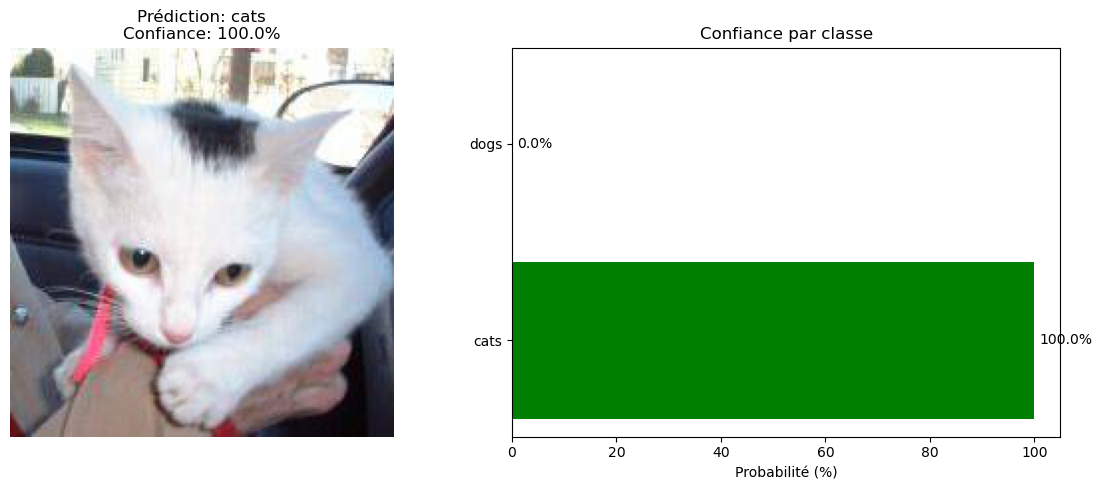


=== RÉSULTAT ===
Classe prédite: cats
Confiance: 99.99%


In [19]:
# Utilisation
classificateur = ClassificateurPersonnalise('mon_classificateur.h5', class_indices)
classe, conf = classificateur.predire_et_afficher('cat.jpg')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluer_modele(model_path, test_dir, class_indices):
    """Évalue le modèle sur le dossier de test et affiche plusieurs métriques"""
    
    # Charger le modèle entraîné
    model = load_model(model_path)
    
    # Inverser class_indices pour récupérer les noms à partir des indices
    classes = {v: k for k, v in class_indices.items()}
    
    # Générateur pour charger les images du test set
    # On ne fait aucune augmentation, juste rescale
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1,             # batch=1 pour prédire image par image
        class_mode='categorical',
        shuffle=False             # IMPORTANT pour aligner y_true et y_pred
    )
    
    # Prédictions sur tout le set test
    print("Prédiction sur le test set...")
    predictions = model.predict(test_generator, verbose=1)
    
    # y_pred = indice de la classe la plus probable
    y_pred = np.argmax(predictions, axis=1)
    
    # y_true = classes réelles fournies par le générateur
    y_true = test_generator.classes
    
    # Obtenir les noms des classes dans l'ordre des indices
    class_names = [classes[i] for i in sorted(classes.keys())]
    
    # RAPPORT DE CLASSIFICATION 
    print("\n" + "="*60)
    print("RAPPORT DE CLASSIFICATION")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    #  MATRICE DE CONFUSION 
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.tight_layout()
    plt.show()
    
    # ACCURACY GLOBALE 
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"\nPrécision globale: {accuracy*100:.2f}%")
    
    # ANALYSE DES ERREURS 
    print("\n" + "="*60)
    print("ANALYSE DES ERREURS")
    print("="*60)
    
    errors = []
    # On parcourt chaque prédiction et on stocke celles qui sont fausses
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            errors.append({
                'index': i,
                'true': classes[y_true[i]],      # nom de la vraie classe
                'pred': classes[y_pred[i]],      # nom de la fausse classe prédite
                'confidence': predictions[i][y_pred[i]]  # confiance du modèle dans son erreur
            })
    
    print(f"Nombre d'erreurs: {len(errors)}")
    
    # Afficher les erreurs les plus "sûres" du modèle (où il s'est trompé avec forte confiance)
    if len(errors) > 0:
        print("\nTop 5 erreurs avec plus haute confiance:")
        errors_sorted = sorted(errors, key=lambda x: x['confidence'], reverse=True)
        for i, err in enumerate(errors_sorted[:5], 1):
            print(f"{i}. Vraie classe: {err['true']}, "
                  f"Prédite: {err['pred']}, "
                  f"Confiance: {err['confidence']*100:.1f}%")
    
    return cm, accuracy, errors


Found 1000 images belonging to 2 classes.
Prédiction sur le test set...


/Users/bayala/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

        cats       0.98      0.98      0.98       500
        dogs       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



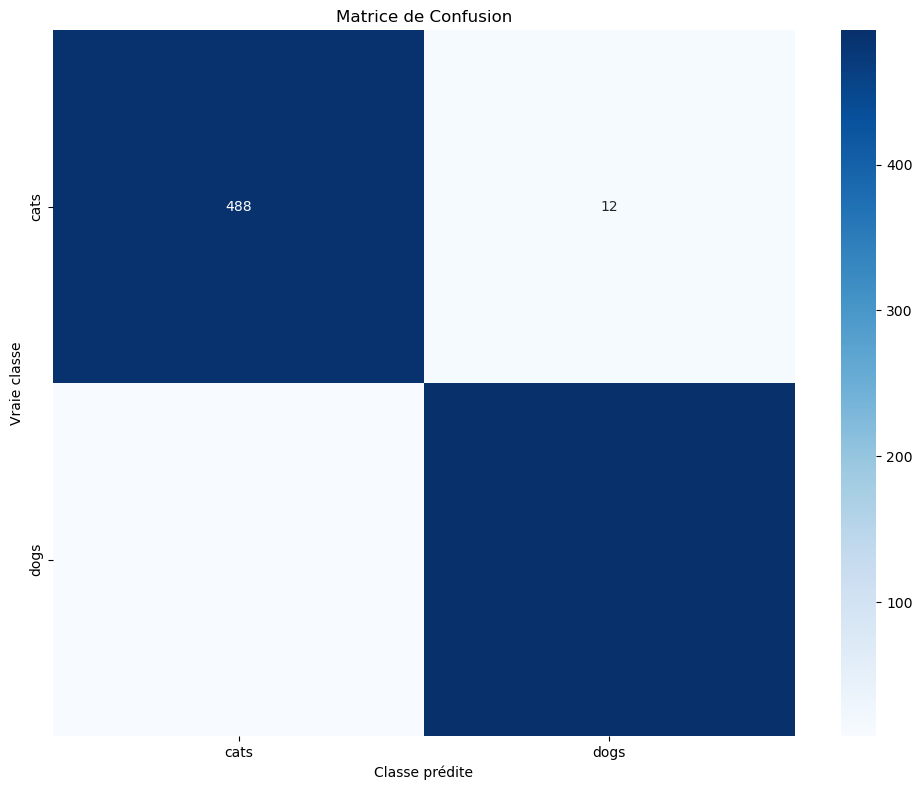


Précision globale: 98.00%

ANALYSE DES ERREURS
Nombre d'erreurs: 20

Top 5 erreurs avec plus haute confiance:
1. Vraie classe: cats, Prédite: dogs, Confiance: 99.3%
2. Vraie classe: cats, Prédite: dogs, Confiance: 98.5%
3. Vraie classe: dogs, Prédite: cats, Confiance: 98.2%
4. Vraie classe: cats, Prédite: dogs, Confiance: 95.2%
5. Vraie classe: dogs, Prédite: cats, Confiance: 94.1%


In [21]:
# Utilisatio
cm, acc, errors = evaluer_modele(
    'mon_classificateur.h5',
    'test',
    class_indices
)

Streamlit est un framework Python qui permet de créer facilement des applications web interactives, surtout pour la Data Science, l’IA et le Machine Learning, sans avoir besoin de faire du HTML, CSS ou JavaScript.

In [ ]:
import streamlit as st          # Importe la bibliothèque Streamlit pour créer l'interface web
from PIL import Image           # Importe PIL pour manipuler les images

class AppClassification:        # Définition d'une classe pour encapsuler toute l'application
    """Application Streamlit pour classification d'images"""
    
    def __init__(self, model_path, class_indices):
        self.model = load_model(model_path)      # Charge le modèle Keras à partir du chemin donné
        # Inverse le dictionnaire class_indices : {index -> nom de classe}
        self.classes = {v: k for k, v in class_indices.items()}
    
    def predire(self, img):
        """Prédit la classe d'une image PIL"""
        img = img.resize((224, 224))              # Redimensionne l'image à la taille attendue
        img_array = np.array(img) / 255.0         # Convertit en array et normalise les pixels entre 0 et 1
        img_array = np.expand_dims(img_array, axis=0) # Ajoute une dimension (batch de 1 image)
        
        predictions = self.model.predict(img_array, verbose=0) # Fait la prédiction avec le modèle
        class_idx = np.argmax(predictions[0])                 # Récupère l'indice de la classe la plus probable
        confidence = predictions[0][class_idx]                # Probabilité associée à cette classe
        class_name = self.classes[class_idx]                  # Nom humain de la classe prédite
        
        return class_name, confidence, predictions[0]         # Retourne classe, confiance et toutes les probabilités
    
    def run(self):
        """Lance l'application Streamlit"""
        st.title("�� Classificateur d'Images Personnalisé")   # Titre de la page
        st.write("Uploadez une image pour la classifier")     # Texte d'instruction
        
        # Upload
        uploaded_file = st.file_uploader(                     # Widget pour téléverser une image
            "Choisissez une image",
            type=['jpg', 'jpeg', 'png']
        )
        
        if uploaded_file is not None:                         # Si un fichier a été uploadé
            # Afficher l'image
            img = Image.open(uploaded_file)                   # Ouvre l'image avec PIL
            st.image(img, caption='Image uploadée', use_column_width=True) # Affiche l'image
            
            # Prédire
            with st.spinner('Classification en cours...'):    # Affiche un spinner pendant le calcul
                class_name, confidence, all_probs = self.predire(img)
            
            # Résultat principal
            st.success(f"**Classe prédite:** {class_name}")   # Affiche la classe prédite
            st.info(f"**Confiance:** {confidence*100:.2f}%")  # Affiche la confiance formatée
            
            # Toutes les probabilités
            st.subheader("Probabilités pour chaque classe")   # Sous-titre
            
            prob_df = pd.DataFrame({                          # Crée un DataFrame pour afficher les scores
                'Classe': [self.classes[i] for i in range(len(all_probs))],
                'Probabilité (%)': all_probs * 100
            }).sort_values('Probabilité (%)', ascending=False)
            
            st.bar_chart(prob_df.set_index('Classe'))         # Histogramme des probabilités
            st.dataframe(prob_df)                             # Affiche les données sous forme de tableau

# Pour lancer l'app:
# streamlit run app.py

if __name__ == '__main__':                            # Point d'entrée du programme
    app = AppClassification('mon_classificateur.h5', class_indices)   # Instancie l'application
    app.run()                                          # Lance l'app Streamlit


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 60)